In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#preliminary test to ensure GPU is working

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#preliminary test to check CPU Vs GPU time

import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.538984092003375
GPU (s):
0.036736055997607764
GPU speedup over CPU: 96x


In [11]:
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
#import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [16]:
artists = pd.read_csv(r'art5.csv')
artists.shape

(5, 8)

In [17]:
#specify the directory containing the image-training set

images_dir = r'train'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists['name'].str.replace(' ', '_').values

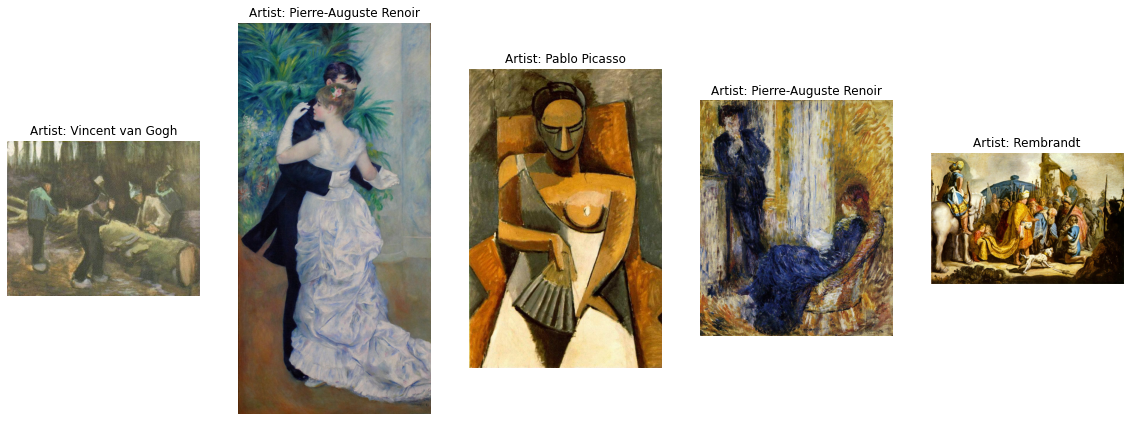

In [18]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [19]:
batch_size = 1
train_input_shape = (256, 256,3)
n_classes = artists.shape[0]

In [20]:
img_width, img_height = 256, 256

In [22]:
#this section implements the data generation and data augmentation

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=(img_width, img_height),
                                                    color_mode="rgb",
                                                    batch_size=120,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=(img_width, img_height),
                                                    color_mode="rgb",
                                                    batch_size=30,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)



Found 1314 images belonging to 5 classes.
Found 326 images belonging to 5 classes.
Total number of batches = 10 and 10


In [23]:
X_train, y_train = train_generator.next()
X_test, y_test = valid_generator.next()

In [24]:
y_train.shape

(120, 5)

In [25]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [26]:
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
#this section contains the model as described in the author's paper

######start of the encoder part######

input_img = keras.Input(shape=(img_width, img_height, 3))

x = layers.Conv2D(100, (5, 5), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(200, (5, 5), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

#######end of the encoder part#######

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

######start of the decoder part######

x = layers.UpSampling2D((2, 2))(encoded)
x = layers.Conv2DTranspose(200, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(100, (5, 5), activation='relu', padding='same')(x)
decoded = layers.Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [32]:
n_epoch = 200
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, 
                              verbose=1, mode='auto')


In [33]:
history = autoencoder.fit(X_train,X_train,steps_per_epoch=STEP_SIZE_TRAIN,
          epochs=n_epoch,
          validation_data=(X_test,X_test),
          verbose=1,
          callbacks=[reduce_lr],
          batch_size=10,
          )

Epoch 1/200
10/10 [==============================] - 14s 522ms/step - loss: 0.1006 - accuracy: 0.4950 - val_loss: 0.0820 - val_accuracy: 0.6807
Epoch 2/200
10/10 [==============================] - 5s 505ms/step - loss: 0.0758 - accuracy: 0.6521 - val_loss: 0.0461 - val_accuracy: 0.7140
Epoch 3/200
10/10 [==============================] - 5s 498ms/step - loss: 0.0494 - accuracy: 0.6668 - val_loss: 0.0412 - val_accuracy: 0.4513
Epoch 4/200
10/10 [==============================] - 5s 491ms/step - loss: 0.0279 - accuracy: 0.5069 - val_loss: 0.0158 - val_accuracy: 0.5901
Epoch 5/200
10/10 [==============================] - 5s 500ms/step - loss: 0.0166 - accuracy: 0.5540 - val_loss: 0.0164 - val_accuracy: 0.6846
Epoch 6/200
10/10 [==============================] - 5s 484ms/step - loss: 0.0142 - accuracy: 0.6177 - val_loss: 0.0134 - val_accuracy: 0.6636
Epoch 7/200
10/10 [==============================] - 5s 481ms/step - loss: 0.0108 - accuracy: 0.6597 - val_loss: 0.0095 - val_accuracy: 0.711

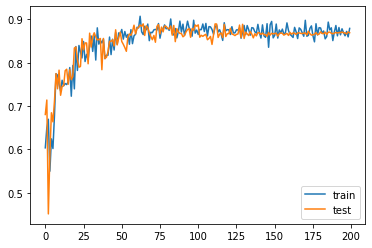

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
# In this section, we construct the artist-classifier CNN. The weights of the autoencoder are saved and loaded into a new model
# called 'model3'. For model3, only the first 5 layer of the autoencoder have been copied - Input, Conv2D, MaxPooling2D, Conv2D,
# and MaxPooling2D. This has been implemented by the function autoencoder.layers[:,-5]. Only the weights for these layers have
# been loaded onto model3. The output of model3 is fed into 2 fully-connected layers (as described in the original paper).
# A Flatten() layer is added just before the fully connected 5-neuron layer with the softmax classifier. Only these Dense()
# layers are trained. Using the for-loop, the encoder-layers have been rendered non-trainable


autoencoder.save_weights('autoencoder.h5')
model3 = tf.keras.models.Sequential(autoencoder.layers[:-5])
model3.load_weights('autoencoder.h5', by_name=True)

x = layers.Dense(400, activation='relu')(model3.output)
x = layers.Dense(200, activation='relu')(x)
x = layers.Flatten()(x)
final = layers.Dense(5, activation='softmax')(x)

for layer in model3.layers[:4]:
    layer.trainable=False

In [36]:
identifier = keras.Model(model3.input,final)
opt = keras.optimizers.Adam(learning_rate=0.0001)
identifier.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
identifier.summary()

In [38]:
history3 = identifier.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=100,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr]
                             )

Epoch 1/100
10/10 [==============================] - 51s 5s/step - loss: 1.4973 - accuracy: 0.3149 - val_loss: 1.3532 - val_accuracy: 0.4200
Epoch 2/100
10/10 [==============================] - 47s 5s/step - loss: 1.2591 - accuracy: 0.4397 - val_loss: 1.3257 - val_accuracy: 0.4933
Epoch 3/100
10/10 [==============================] - 46s 5s/step - loss: 1.1796 - accuracy: 0.4941 - val_loss: 1.1945 - val_accuracy: 0.5067
Epoch 4/100
10/10 [==============================] - 46s 5s/step - loss: 1.1105 - accuracy: 0.5310 - val_loss: 1.2963 - val_accuracy: 0.4600
Epoch 5/100
10/10 [==============================] - 46s 5s/step - loss: 1.1055 - accuracy: 0.5402 - val_loss: 1.2363 - val_accuracy: 0.5100
Epoch 6/100
10/10 [==============================] - 46s 5s/step - loss: 1.1121 - accuracy: 0.5335 - val_loss: 1.1994 - val_accuracy: 0.5467
Epoch 7/100
10/10 [==============================] - 46s 5s/step - loss: 1.0525 - accuracy: 0.5620 - val_loss: 1.1418 - val_accuracy: 0.5433
Epoch 8/100
1

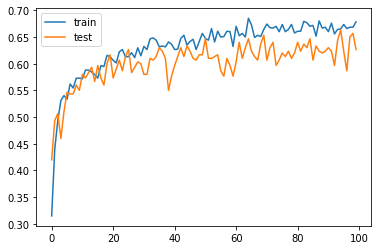

In [39]:
from matplotlib import pyplot
pyplot.plot(history3.history['accuracy'], label='train')
pyplot.plot(history3.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()